In [4]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# This cell allows for all the output to be displayed without scrolling (up to the max-height var in pixels)

In [26]:
import importlib

# List of required libraries
libraries = [
    'ipywidgets',
    'IPython',
    'scipy',
    'numpy',
    'matplotlib',
    'tqdm',
    'pandas',
    'pybaselines',
    'spe2py'
]


# Check if each library is installed, and install if necessary
for library in libraries:
    try:
        importlib.import_module(library)
        print(f"{library} is already installed")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} installed successfully")

# Import the required packages
from helpers import *
from ipywidgets import *
from IPython.display import display, Javascript
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.signal import medfilt
from scipy import signal
import peakutils
from peakutils.plot import plot as pplot
from matplotlib.animation import FuncAnimation
from scipy import stats
from numpy.fft import fft, fftfreq, ifft
import glob
from tqdm import tqdm
import pandas as pd


ipywidgets is already installed
IPython is already installed
scipy is already installed
numpy is already installed
matplotlib is already installed
tqdm is already installed
pandas is already installed
pybaselines is already installed
spe2py is already installed


In [6]:
## Scientific Constants

h = 6.626e-34 #Planck's constant in Js
heV = 4.136e-15 #Planck's constant in eVs
c = 2.9979e8 #Speed of light in m/s
kb = 1.381e-23 #Boltzmann constant in J/K
kbeV = 8.617e-5 #Boltzmann constant in eV/K
scale = 2e-9
#pixelArea = (20e-6)*(20e-6)*100; # LN Spectrometer Area of 100, 20um x 20um pixels per wavelength
pixelArea = (14e-6)*(200e-6); # Ocean Optics UV Vis 14um x 200um per wavelength
# acquisitionTime = 0.5; # Acquisition time is seconds

In [8]:
class OceanOpticsDataReader:
    def __init__(self):
        pass
    
    def get_ocean_optics_data(self, f):
        with open(f, 'r') as file:
            first_line = file.readline()
            if first_line.startswith("Data from"):
                # Skip lines until the ">>>>>Begin Spectral Data<<<<<" marker is found
                for line in file:
                    if line.strip() == ">>>>>Begin Spectral Data<<<<<":
                        break
            else:
                file.seek(0)  # Return to the beginning of the file
            
            # Read the data into a DataFrame
            data = pd.read_csv(file, sep=None, engine='python', names=['col_a_data', 'col_b_data'])
        
        x = data['col_a_data'].to_numpy()
        y = data['col_b_data'].to_numpy()
    
        return x, y
    
    def get_multiple_ocean_optics_data(self, f, i):
        with open(f[i], 'r') as file:
            first_line = file.readline()
            if first_line.startswith("Data from"):
                # Skip lines until the ">>>>>Begin Spectral Data<<<<<" marker is found
                for line in file:
                    if line.strip() == ">>>>>Begin Spectral Data<<<<<":
                        break
            else:
                file.seek(0)  # Return to the beginning of the file
            
            # Read the data into a DataFrame
            data = pd.read_csv(file, sep=None, engine='python', names=['col_a_data', 'col_b_data'])
        
        x = data['col_a_data'].to_numpy()
        y = data['col_b_data'].to_numpy()
    
        return x, y


In [74]:
class DataProcessing:
    
    def __init__(self):
        """
        Initialize the DataProcessing class.

        Parameters:
        - h: Planck's constant (default: 6.626e-34 Js)
        - c: Speed of light (default: 2.9979e8 m/s)
        - k: Boltzmann constant (default: 1.381e-23 J/K)
        - pixelArea: Pixel area (default: 14e-6 * 200e-6 m^2)
        """
        ## Scientific Constants

        self.h = 6.626e-34 #Planck's constant in Js
        self.heV = 4.136e-15 #Planck's constant in eVs
        self.c = 2.9979e8 #Speed of light in m/s
        self.k = 1.381e-23 #Boltzmann constant in J/K
        self.kbeV = 8.617e-5 #Boltzmann constant in eV/K
        self.scale = 2e-9
        #self.pixelArea = (20e-6)*(20e-6)*100; # LN Spectrometer Area of 100, 20um x 20um pixels per wavelength
        self.pixelArea = (14e-6)*(200e-6); # Ocean Optics UV Vis 14um x 200um per wavelength
        # self.acquisitionTime = 0.5; # Acquisition time is seconds
        
    def data_cleaning(self, data, erp):
        # Code to remove cosmic rays
        err = erp / 100

        Ndatapts = len(data)
        ydata = data

        for i in range(0, Ndatapts):  # This loop removes hot regions one pixel wide
            if i > 0 and i < Ndatapts - 1:
                if ydata[i] > (1 + err) * ydata[i + 1] and ydata[i] > (1 + err) * ydata[i - 1]:
                    ydata[i] = (ydata[i - 1] + ydata[i + 1]) / 2

        for i in range(0, Ndatapts):  # This loop removes hot regions up to 3 pixels wide
            if i > 1 and i < Ndatapts - 2 and ydata[i] > (1 + err) * ydata[i + 2] and ydata[i] > (1 + err) * ydata[
                i - 2]:
                ydata[i], ydata[i - 1], ydata[i + 1] = (ydata[i - 2] + ydata[i + 2]) / 2, (ydata[i] + ydata[i - 2]) / 2, (
                            ydata[i + 2] + ydata[i]) / 2

        for i in range(0, Ndatapts):  # This loop removes hot regions up to 5 pixels wide
            if i > 4 and i < Ndatapts - 5 and ydata[i] > (1 + err) * ydata[i + 5] and ydata[i] > (1 + err) * ydata[
                i - 5]:
                ydata[i], ydata[i - 1], ydata[i - 2], ydata[i - 3], ydata[i - 4], ydata[i + 1], ydata[i + 2], ydata[
                    i + 3], ydata[i + 4] = (ydata[i - 5] + ydata[i + 5]) / 2, (ydata[i] + ydata[i - 2]) / 2, (
                                                          ydata[i - 1] + ydata[i - 3]) / 2, (
                                                          ydata[i - 2] + ydata[i - 4]) / 2, (
                                                          ydata[i - 3] + ydata[i - 5]) / 2, (
                                                          ydata[i + 2] + ydata[i]) / 2, (
                                                          ydata[i + 3] + ydata[i + 1]) / 2, (
                                                          ydata[i + 4] + ydata[i + 2]) / 2, (
                                                          ydata[i + 5] + ydata[i + 3]) / 2

        for i in range(0, Ndatapts):  # This loop removes dead regions one pixel wide
            if i > 0 and i < Ndatapts - 1 and ydata[i] < (1 - err) * ydata[i + 1] and ydata[i] < (1 - err) * ydata[i - 1]:
                ydata[i] = (ydata[i - 1] + ydata[i + 1]) / 2

        for i in range(0, Ndatapts):  # This loop removes dead regions up to 3 pixels wide
            if i > 1 and i < Ndatapts - 2 and ydata[i] < (1 - err) * ydata[i + 2] and ydata[i] < (1 - err) * ydata[
                i - 2]:
                ydata[i], ydata[i - 1], ydata[i + 1] = (ydata[i - 2] + ydata[i + 2]) / 2, (ydata[i] + ydata[i - 2]) / 2, (
                            ydata[i + 2] + ydata[i]) / 2

        return ydata

    def subtract_bsl(self, data, p_order):
        base = peakutils.baseline(data, p_order)
        return base

    def filter_savgol(self, data, k_size, p_order):
        data[np.isnan(data)] = 0
        sav_filt_data = signal.savgol_filter(data, k_size, p_order)
        return sav_filt_data

    def filter_median(self, data, k_size):
        filt_data = medfilt(data, kernel_size=k_size)
        return filt_data

    def data_averaging(self, selectFiles, average, batching, batch_size,
                       final_file_name='-averaged_data.csv'):
        fdata = selectFiles.files

        if len(fdata) < 2:
            print("Please select at least 2 files to average")

        head_i, tail_i = os.path.split(fdata[0])
        y_all = []
        for idx, file in enumerate(fdata):
            x_data, y_data, metadata = DataReader(file_name=file).read_file()
            y_all.append(y_data)

        column_vectors = [np.expand_dims(arr, axis=1) for arr in y_all]

        # Concatenate the column vectors along the axis=1
        concatenated_array = np.concatenate(column_vectors, axis=1)
        average_array = concatenated_array

        average_batches = []

        if batching == True:
            # Get the total number of elements and batches
            total_elements = concatenated_array.shape[1]
            total_batches = total_elements // batch_size

            # Calculate the median within each batch
            for i in range(total_batches):
                start_idx = i * batch_size
                end_idx = (i + 1) * batch_size
                batch_concat = np.concatenate(column_vectors[:][start_idx:end_idx], axis=1)
                batch_average = np.average(batch_concat, axis=1)
                average_batches.append(batch_average)

                # Save each batch_median to a CSV file
                batch_filename = f'-batch_average_{i + 1}.csv'
                total_median_data = np.column_stack((x_data, batch_average))
                np.savetxt(os.path.join(head_i, tail_i[:-13] + batch_filename), total_median_data, delimiter=',')

        averaged_data = np.average(y_all, axis=1)
        total_average_data = np.column_stack((x_data, averaged_data))
        np.savetxt(os.path.join(head_i, tail_i[:-13] + final_file_name), total_average_data, delimiter=',')

        return x_data, averaged_data
    
    def i_corr(self, f, flamp):
        start = 0
        end = -1

        head_i, tail_i = os.path.split(f)
        
        data_reader = OceanOpticsDataReader()

        ## Important note to change the location of this .txt file below to where it is in your computer.
        calibstd = np.loadtxt(r"G:\Shared drives\Pauzauskie Team Drive\Users\CG\Scripts\030410638_HL-2000-CAL_2014-01-15-14-09_VISEXT1EXT2_FIB.txt")
        xcalib = calibstd[:,0]
        ycalib = calibstd[:,1]

        x, y = data_reader.get_ocean_optics_data(f)

        HglampFunc = CubicSpline(xcalib, ycalib)
        hglampI = HglampFunc(x) # Create interpolation of true lamp spectrum

        hglampdata_x, hglampdata_y = data_reader.get_multiple_ocean_optics_data(flamp, 0) # Split true lamp spectra into x and y

        ICF = hglampI / (hglampdata_y) # Creates ratio of true lamp spectra to real lamp data, ICF = Intensity Correction Factor
        ynew = (y) * ICF # multiplies real data by intensity correction factor

        ynew = np.nan_to_num(ynew, nan=0, posinf=0, neginf=0)
        datamatrix = np.column_stack((x, ynew)) # Compiles corrected data into a new matrix

        plt.figure()
        plt.plot(x, ynew / np.max(ynew), label='Intensity Corrected Data')
        plt.plot(x, y / np.max(y), label='Actual Data')
        plt.legend()
        plt.show()

        return x, y, ynew
    
    def blackbody_lam_norm(self, lam, T):
        """
        Calculate blackbody spectral radiance as a function of wavelength (um) and temperature (K).

        Parameters:
        - lam: Array of wavelengths (in micrometers)
        - T: Blackbody temperature (in Kelvin)

        Returns:
        - spectral_radiance: Array of spectral radiance values (in W/m^2-nm)
        """
        lam = 1e-9 * lam  # Convert wavelength to meters
        fun_val = (3.14 * (2 * self.h * self.c ** 2 / (lam ** 5 * (np.exp(self.h * self.c / (lam * self.k * T)) - 1)))) / 1e9
        return fun_val / np.max(fun_val)
    
    def blackbody_lam(self, lam, T):
        """
        Calculate blackbody spectral radiance as a function of wavelength (um) and temperature (K).

        Parameters:
        - lam: Array of wavelengths (in micrometers)
        - T: Blackbody temperature (in Kelvin)

        Returns:
        - spectral_radiance: Array of spectral radiance values (in W/m^2-nm)
        """
        lam = 1e-9 * lam  # Convert wavelength to meters
        fun_val = (3.14 * (2 * self.h * self.c ** 2 / (lam ** 5 * (np.exp(self.h * self.c / (lam * self.k * T)) - 1)))) / 1e9
        return fun_val


In [11]:
do_intensity_corr_data_cleaning = 'y'

if do_intensity_corr_data_cleaning == 'y':
    
    do_median_filtering = 'n'
    do_data_cleaning = 'n'
    erp = 10 
    k_size = 3
    
    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp_1 = SelectFilesButton()
    display(selectHalLamp_1)
else:
    pass


Select tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction 
(optional; if none is chosen, default intensity correction factor will be used): 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


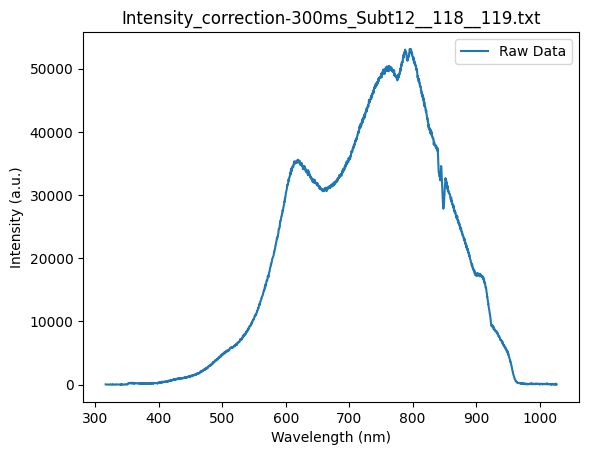

In [24]:
# Create an instance of the DataProcessing class
data_processor = OceanOpticsDataReader()

# Define your processing options
do_median_filtering = 'n'
do_savgol_filtering = 'n'
do_data_cleaning = 'n'
erp = 10
k_size = 3
k_size_savgol = 51
p_order_savgol = 1

if do_intensity_corr_data_cleaning == 'y':

    flamp_1 = selectHalLamp_1.files

    for i in tqdm(range(len(flamp_1))):

        head, tail = os.path.split(flamp_1[i])

        x_data, y_data = data_processor.get_multiple_ocean_optics_data(flamp_1, i)

        if do_savgol_filtering == 'y':
            savgol_filt_data = data_processor.filter_savgol(y_data, k_size_savgol, p_order_savgol)
        else:
            savgol_filt_data = y_data

        if do_median_filtering == 'y':
            filt_data = data_processor.filter_median(savgol_filt_data, k_size)
        else:
            filt_data = savgol_filt_data

        if do_data_cleaning == 'y':
            cleaned_data = data_processor.data_cleaning(filt_data, erp)
        else:
            cleaned_data = filt_data

        max_val_intensity = 3000  # Set the value of intensity that an intensity correction file should have to get considered

        if np.max(cleaned_data) > max_val_intensity:
            # print(flamp_1[i])

            datamatrix = np.column_stack((x_data, cleaned_data))  # Compiles corrected data into a new matrix
            savename = flamp_1[i][:-4] + "_cleaned.txt"  # Create filename for new data
            # np.savetxt(savename, datamatrix)  # Save new data

            plt.plot(x_data, y_data, label='Raw Data')
            # plt.plot(x_data, cleaned_data, label='Cleaned Data')
            # plt.plot(x_data,filt_data)
            # plt.plot(x_data,savgol_filt_data)

            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Intensity (a.u.)')
            # plt.ylim(0,1000)
            plt.legend()
            # plt.ylim(100,250)
            plt.title(tail)
    plt.show()
else:
    pass

In [14]:
print("Select data files you want intensity corrected: ")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'y'

if do_intensity_correction == 'y':
    print("Select data dark BKG: (Optional, don't use if background already subtracted)")
    selectDark = SelectFilesButton()
    display(selectDark)
    print("________________________________________________________________________________________________________")

    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)

    print("\nSelect baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)")
    selectBaseline = SelectFilesButton()
    display(selectBaseline)
    print("________________________________________________________________________________________________________")

else:
    pass

Select data files you want intensity corrected: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

Select data dark BKG: (Optional, don't use if background already subtracted)


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

________________________________________________________________________________________________________

Select tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction 
(optional; if none is chosen, default intensity correction factor will be used): 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))


Select baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

________________________________________________________________________________________________________


In [92]:
## Variables for Planck's fitting

acquisitionTime = 0.1 # 500ms acquistion time
#T0 = 1000 # Initial temperature guess in degrees K

do_intensity_correction = 'y'
do_baseline_subtraction = 'n'
do_median_filtering = 'n'
do_data_cleaning = 'n'
p_order = 5 # Polynomial order for baseline subtraction
k_size = 3 # Kernel size for Median Filtering
erp = -11

wvl_start = 440 # Wavelength start range to fit in nm
wvl_end = 600 # Wavelength end range to fit in nm
T0 = 1000 # Initial temperature guess in degrees K

Integration time: 0.000497 s


C:\Users\Pauzauskie\AppData\Local\Temp\ipykernel_3544\2002470217.py:146: RuntimeWarning: divide by zero encountered in divide
  ICF = hglampI / (hglampdata_y) # Creates ratio of true lamp spectra to real lamp data, ICF = Intensity Correction Factor


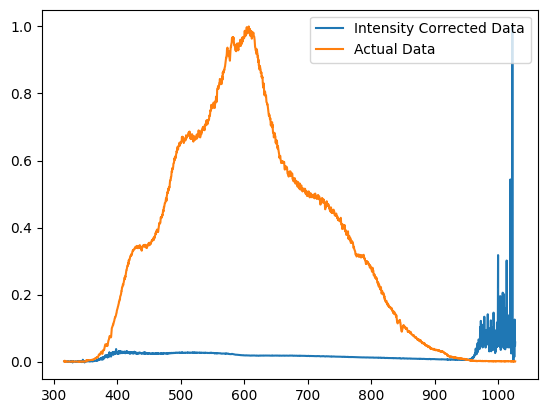

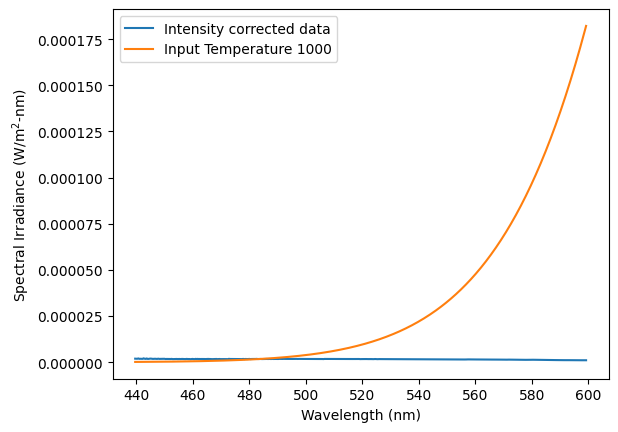

                                           file_name  Temperature(K)
1  G4_CA-Exp_16-LH_R3-loc_1_Subt16__34845__71527.txt     1581.428732


In [95]:
# Create instances of the classes
data_reader = OceanOpticsDataReader()
data_processor = DataProcessing()

df_1 = pd.DataFrame(columns=['file_name', 'Temperature(K)'])
counter = 0

files = selectFiles.files

for file in files:
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('Integration Time (sec):'):
                integration_time = line.split(':')[1].strip()
                acquisitionTime = float(integration_time)
                print(f'Integration time: {acquisitionTime} s')

    head, tail = os.path.split(file)

    # print(head)
    # print(tail)
    # print(file)

    counter = counter + 1

    x_data, y_data = data_reader.get_ocean_optics_data(file)
    # print(x_data,y_data)

    if do_intensity_correction == 'y':
        x_data, y_data, intens_data = data_processor.i_corr(file, flamp)
    else:
        intens_data = y_data

    # norm_intens_data = intens_data/np.max(intens_data)
    norm_intens_data = intens_data

    if do_median_filtering == 'y':
        filt_data = data_processor.filter_median(norm_intens_data, k_size)
    else:
        filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = data_processor.subtract_bsl(filt_data, p_order)
    else:
        base = 0

    bsl_subt_data = filt_data - base

    if do_data_cleaning == 'y':
        cleaned_data = data_processor.data_cleaning(bsl_subt_data, erp)
    else:
        cleaned_data = bsl_subt_data

    # Plancks fitting process

    pixelResolution = (x_data[-1] - x_data[-2])  # delta wavelength nm
    # print('Pixel Resolution = ' + str(pixelResolution))

    y_spec_irr = np.zeros(shape=len(x_data))
    photonFlux = np.zeros(shape=len(cleaned_data))
    for j in range(len(x_data)):
        photonFlux[j] = cleaned_data[j] / (pixelArea * acquisitionTime)
        y_spec_irr[j] = photonFlux[j] * (h * c / (x_data[j] * 10 ** -9)) / (pixelResolution)  # spectral irradiance in W/m^2-nm

    # y_spec_irr_norm = y_spec_irr/np.max(y_spec_irr)
    # y_spec_irr_norm = (y_spec_irr - np.min(y_spec_irr))/(np.max(y_spec_irr)-np.min(y_spec_irr))
    y_spec_irr_norm = y_spec_irr

    # print(x)
    start = np.argmin(abs(x_data[1:] - wvl_start))
    end = np.argmin(abs(x_data[1:] - wvl_end))
    # print(start, end)
    wa = x_data[start:end]
    ydata_1 = y_spec_irr_norm[start:end]

    popt, pcov = curve_fit(data_processor.blackbody_lam, wa, ydata_1/max(ydata_1), p0=T0)

    # get the best fitting parameter values and their 1 sigma errors
    # (assuming the parameters aren't strongly correlated).

    bestT1 = popt
    sigmaT1 = np.sqrt(np.diag(pcov))

    ybest = data_processor.blackbody_lam(wa, bestT1)
    yblack = data_processor.blackbody_lam(wa, T0)

    df_1.loc[counter] = [tail, bestT1[0]]

    # degrees_of_freedom
        # degrees_of_freedom = len(wa) - 2
    # resid = (ydata_1 - ybest) / sigmaT1
    # chisq = np.dot(resid, resid)

    # #print(degrees_of_freedom, 'dof')
    # print('chi squared %.2f' % chisq) 
    # #print('nchi2 %.2f' % (chisq / degrees_of_freedom))
    
    # plot the solution
    plt.plot(wa,ydata_1,label='Intensity corrected data')
    #plt.xlim(360,850)
    #plt.ylim(0,15)
    plt.plot(wa,yblack,label='Input Temperature %d'%T0)
    # plt.plot(wa, ybest, label='Best fitting model %d'%bestT1)
    # plt.title(tail_i)
    plt.ylabel("Spectral Irradiance (W/m$^2$-nm)")
    plt.xlabel("Wavelength (nm)")
    plt.legend(frameon=True)
    #plt.savefig('')
    plt.show()
print(df_1)
# df_1.to_csv(r'temp_val_2.csv',index=False,header=True)

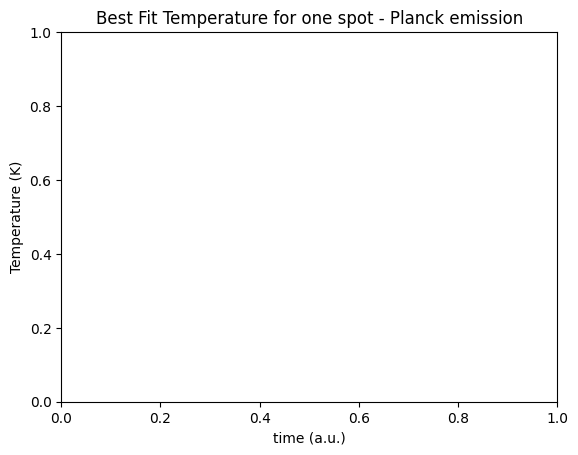

In [76]:
# df_1 = pd.read_csv('temp_val_2.csv')

x = df_1['file_name'].to_numpy()
y = df_1['Temperature(K)'].to_numpy()

#fig1 = plt.figure()
#plt.axis([0, 10, 0, 1])

#for i in range(316):
    #y = np.random.random()
for idx, yi in enumerate(y):
    if yi>1200:
        plt.scatter(idx,yi)
plt.xlabel('time (a.u.)')
plt.ylabel('Temperature (K)')
plt.title('Best Fit Temperature for one spot - Planck emission')
    #plt.pause(0.05)

plt.show()

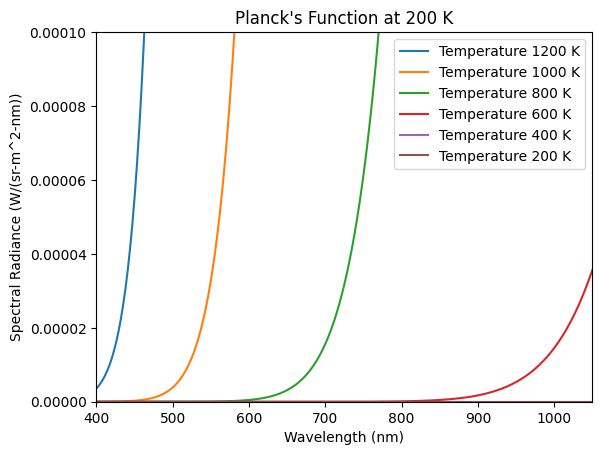

In [86]:
def plot_plancks_function(temperature, wavelength_range=(100, 1000)):
    """
    Plot Planck's function for a given temperature.

    Parameters:
    - temperature: Blackbody temperature (in Kelvin)
    - wavelength_range: Tuple specifying the wavelength range (in nm) to plot (default: 100 to 1000 nm)
    """
    wavelength = np.linspace(wavelength_range[0], wavelength_range[1], 500)
    data_processor = DataProcessing()
    spectral_radiance = data_processor.blackbody_lam(wavelength, temperature)

    # plt.figure()
    plt.plot(wavelength, spectral_radiance, label=f'Temperature {temperature} K')
    plt.xlim(400,wavelength_range[1])
    plt.ylim(0,0.0001)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral Radiance (W/(sr-m^2-nm))")
    plt.legend()
    plt.title(f'Planck\'s Function at {temperature} K')

def plot_multiple_temperatures(temperatures, wavelength_range=(100, 1000)):
    """
    Plot Planck's functions for multiple temperatures.

    Parameters:
    - temperatures: List of blackbody temperatures (in Kelvin)
    - wavelength_range: Tuple specifying the wavelength range (in nm) to plot (default: 100 to 1000 nm)
    """
    for temp in temperatures:
        plot_plancks_function(temp, wavelength_range)

    plt.show()

# Usage example
if __name__ == "__main__":
    temperatures = [1200, 1000, 800, 600, 400, 200]
    for temp in temperatures:
        plot_plancks_function(temp, wavelength_range=(300, 1050))
    # plot_multiple_temperatures(temperatures)
    plt.show()
